## DRO Orbits playground

This code generates distant retrograde orbits (DROs) in the Sun-Earth system depending on the distance from the Sun     
part of https://github.com/cmoestl/dro_orbits
 
Authors: C. Möstl, Austrian Space Weather Office, GeoSphere Austria    
https://bsky.app/profile/chrisoutofspace.bsky.social, https://github.com/cmoestl

last update: October 2025
 
uses conda environment *dro* (for environment file, see folder env)

---
### Issues

- streamline calculation: write out results of function directly as recarrays
- each solution needs a time axis (in hours)
- distribute spacecraft with better resolution (not days)
---


### Ideas
- movie in HCI with more spacecraft
- plotly plot with clickable positions



In [1]:
import time
import os
import requests
import numpy as np
import datetime
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.dates as mdates
from matplotlib.ticker import MultipleLocator
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.cm as cm
from matplotlib.patches import Rectangle

import pickle
import spiceypy
import pandas as pd
import seaborn as sns
from scipy.integrate import solve_ivp
from scipy import stats
from scipy.signal import argrelextrema
import multiprocessing as mp

import astropy.units as u
from astropy import constants as const

au=const.au.value*1e-3
M_sun = const.M_sun.value  # Sun mass
M_earth = const.M_earth.value   # Earth mass
G=const.G.value*1e-9 # use km
# Sun-Earth system parameters mu: mass parameter (m2/(m1+m2))
mu = M_earth/(M_sun+M_earth)  # Earth mass / (Sun + Earth mass)

# Calculate system parameters
M_total = M_sun + M_earth
omega = np.sqrt(G * M_total / au**3)  # Angular velocity of rotating frame (rad/s) from keplers laws?
T=2*np.pi/omega/86400 #year in decimal days

print('Au in km:',au) # in km
print('M sun',M_sun)
print('M earth',M_earth)
print('G:',G)

print(f"System Parameters:")
print(f"  Mass parameter μ = {mu:.6e}")
print(f"  Earth-Sun distance au = {au:.6e} km")
print(f"  Angular velocity ω = {omega:.6e} rad/s")
print(f"  Orbital period = {2*np.pi/omega/86400:.2f} days\n")


#plotly if needed
#import plotly.graph_objects as go
#from plotly.offline import iplot, init_notebook_mode
#from plotly.subplots import make_subplots
#import plotly.io as pio
#import plotly.express as px
#pio.renderers.default = 'browser'

kernels_path='kernels'

#make sure to convert the current notebook to a script if you want to run it on a server
os.system('jupyter nbconvert --to script dro.ipynb')   


Au in km: 149597870.70000002
M sun 1.988409870698051e+30
M earth 5.972167867791379e+24
G: 6.6743e-20
System Parameters:
  Mass parameter μ = 3.003480e-06
  Earth-Sun distance au = 1.495979e+08 km
  Angular velocity ω = 1.990987e-07 rad/s
  Orbital period = 365.26 days



[NbConvertApp] Converting notebook dro.ipynb to script
[NbConvertApp] Writing 52290 bytes to dro.py


0

### load planetary orbits
get planetary orbits from spiceypy with files    
load de442.bsp from https://naif.jpl.nasa.gov/pub/naif/generic_kernels/spk/planets/    
other files already available in folder: https://naif.jpl.nasa.gov/pub/naif/generic_kernels/lsk/    
saved in folder /kernels



File already exists at kernels/de442.bsp
['de442.bsp', 'heliospheric_v004u.tf', '.DS_Store', 'naif0012.tls', 'pck00010.tpc']
kernels


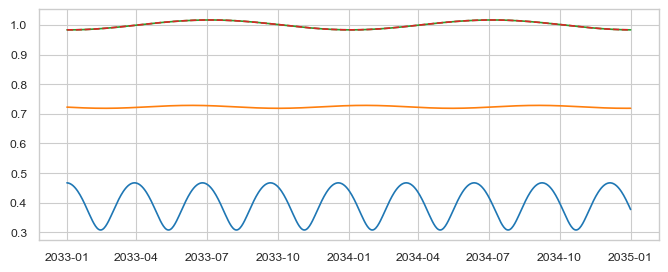

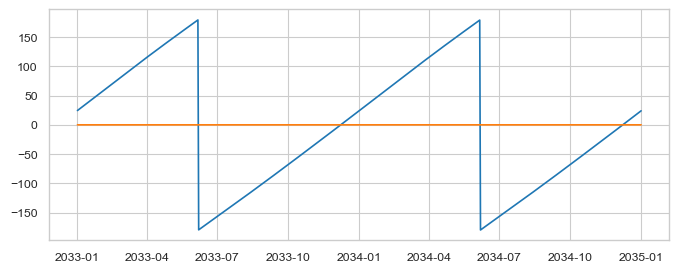

In [2]:
#check if de442.bsp is available, otherwise download

def download_if_not_exist(url, filepath):
    if os.path.exists(filepath):
        print(f"File already exists at {filepath}")
        return filepath
    
    # Create directory if needed
    os.makedirs(os.path.dirname(filepath), exist_ok=True)
    
    # Download
    response = requests.get(url)
    response.raise_for_status()
    
    with open(filepath, 'wb') as f:
        f.write(response.content)
    
    print(f"Downloaded to {filepath}")
    return filepath


filepath='kernels/de442.bsp'
url='https://naif.jpl.nasa.gov/pub/naif/generic_kernels/spk/planets/de442.bsp'

download_if_not_exist(url,filepath)

#use two arbitray years for the planets
start=datetime.datetime(2033,1,1)
end=datetime.datetime(2035,1,1)

times = [] 
dt=24 #time resolution for planets is 1 day
# Generate datetimes with increments of dt hours until the end date
current = start
while current <= end:
    times.append(current)
    current += datetime.timedelta(hours=dt)
    

def cart2sphere_rad(x,y,z):
    
    r = np.sqrt(x**2+ y**2 + z**2) / au
    theta = np.arctan2(z,np.sqrt(x**2+ y**2)) * 360 / 2 / np.pi
    phi = np.arctan2(y,x) * 360 / 2 / np.pi    
    
    theta=np.deg2rad(theta)
    phi=np.deg2rad(phi)
    
    return (r, theta, phi)

def generic_furnish(kernels_path):
    generic_path = kernels_path
    generic_kernels = os.listdir(generic_path)
    print(generic_kernels)    
    #spiceypy.furnsh(os.path.join(generic_path, 'de442.bsp'))
        
    for kernel in generic_kernels:
        spiceypy.furnsh(os.path.join(generic_path, kernel))
        
def get_planet_pos(t,kernels_path, planet):
    if spiceypy.ktotal('ALL') < 1:
        generic_furnish(kernels_path)
    pos = spiceypy.spkpos(planet, spiceypy.datetime2et(t), "HEEQ", "NONE", "SUN")[0]
    r, lat, lon = cart2sphere_rad(pos[0],pos[1],pos[2])
    position = t, pos[0], pos[1], pos[2], r, lat, lon
    return position


def get_planet_positions(time_series,kernels_path,planet):
    positions = []
    for t in time_series:
        position = get_planet_pos(t,kernels_path, planet)
        positions.append(position)
    df_positions = pd.DataFrame(positions, columns=['time', 'x', 'y', 'z', 'r', 'lat', 'lon'])
    return df_positions



def get_planet_pos_hci(t,kernels_path, planet):
    if spiceypy.ktotal('ALL') < 1:
        generic_furnish(kernels_path)
    pos = spiceypy.spkpos(planet, spiceypy.datetime2et(t), "HCI", "NONE", "SUN")[0]
    r, lat, lon = cart2sphere_rad(pos[0],pos[1],pos[2])
    position = t, pos[0], pos[1], pos[2], r, lat, lon
    return position


def get_planet_positions_hci(time_series,kernels_path,planet):
    positions = []
    for t in time_series:
        position = get_planet_pos_hci(t,kernels_path, planet)
        positions.append(position)
    df_positions = pd.DataFrame(positions, columns=['time', 'x', 'y', 'z', 'r', 'lat', 'lon'])
    return df_positions





# make Earth Mercury and Venus positions
generic_furnish(kernels_path)    
print(kernels_path)
mercury=get_planet_positions(times,kernels_path, 'MERCURY_BARYCENTER')
venus=get_planet_positions(times,kernels_path, 'VENUS_BARYCENTER')
earth=get_planet_positions(times,kernels_path, 'EARTH_BARYCENTER')

earth_hci=get_planet_positions_hci(times,kernels_path, 'EARTH_BARYCENTER')



#to matplotlib datenumber
#mercury.time=mdates.date2num(mercury.time)
#venus.time=mdates.date2num(venus.time)
#earth.time=mdates.date2num(earth.time)


sns.set_style('whitegrid')
sns.set_context('paper')   
# Create the plot
fig, ax = plt.subplots(figsize=(8, 3),dpi=100)
plt.plot(mercury.time,mercury.r,'-')
plt.plot(venus.time,venus.r,'-')
plt.plot(earth.time,earth.r,'-')
plt.plot(earth_hci.time,earth_hci.r,'--')

fig, ax = plt.subplots(figsize=(8, 3),dpi=100)
plt.plot(earth_hci.time,np.rad2deg(earth_hci.lon))
plt.plot(earth.time,np.rad2deg(earth.lon))






### CR3BP simulation (circular restricted 3 Body Problem)

equations adapted from https://jan.ucc.nau.edu/~ns46/student/2010/Frnka_2010.pdf

In [3]:
def cr3bp_equations(t, state):
    """
    Equations of motion for the Circular Restricted 3-Body Problem
    in the rotating reference frame with physical units.    
    state = [x, y, vx, vy] in km and km/s
    """
    x, y, vx, vy = state
    
    # Positions of the primaries in rotating frame
    x1 = -mu * au  # Sun position
    x2 = (1 - mu) * au  # Earth position
    
    # Distances to the two primaries
    r1 = np.sqrt((x - x1)**2 + y**2)
    r2 = np.sqrt((x - x2)**2 + y**2)
    
    # need to check these equations with Frnka 2010
    ax = (2*omega*vy + omega**2*x - G*M_sun*(x - x1)/r1**3 - G*M_earth*(x - x2)/r2**3)    
    ay = (-2*omega*vx + omega**2*y - G*M_sun*y/r1**3 - G*M_earth*y/r2**3)
    
    return [vx, vy, ax, ay]


def make_dro(initial_state,years):

    days = 365*years  # Simulate for n years
    t_span = (0, days * 86400)      # Time span for integration (in seconds)
    t_eval = np.linspace(t_span[0], t_span[1], days*24) #time resolution is 1 hour, need to include better for arbitrary time arrays

    #days = T*years  # Simulate for n years
    #t_span = (0, int(days * 86400))      # Time span for integration (in seconds)
    #t_eval = np.linspace(t_span[0], t_span[1], 60*60) #time resolution is 60 sec * 60 min = 1 hour   


    
    #print("Integration started")
    # Solve the differential equations
    solution = solve_ivp(cr3bp_equations, t_span, initial_state,  t_eval=t_eval, method='DOP853', rtol=1e-10, atol=1e-8)

    # Extract trajectory, convert to au
    x = solution.y[0]/au; y = solution.y[1]/au

    #print("Integration done")
    
    return x,y


### Numerical simulation

[np.float64(0.9500000000000001), np.float64(0.9), np.float64(0.85), np.float64(0.8), np.float64(0.75)]
[3.035, 6.1297, 9.3298, 12.6525, 16.1142]
done
done
orbits written into orbit_files/dro.p


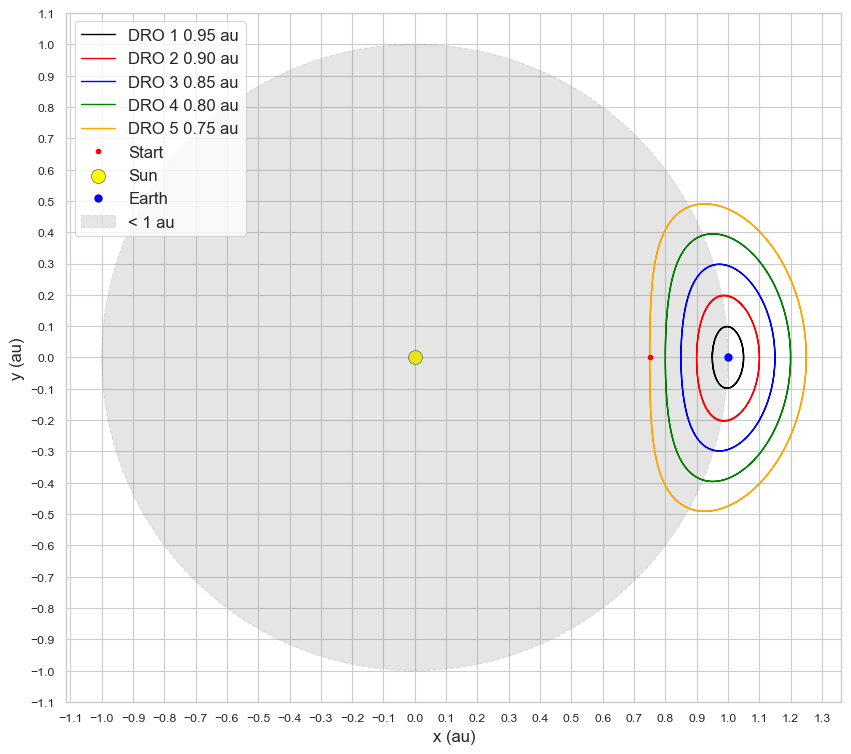

In [4]:
###################### find dro solutions by trial and error

#list for initial conditions
initial_x0_array=[]
initial_vy_array=[]

########### solution for 0.95 au is manually found 3.035 km/s; check minimization, Method 1 not quite right for the 0.95 au case
x0 = 0.95*au  # km (between Sun and Earth)
y0 = 0  # km
vx0 = 0  # km/s
#vy0 =  3.0494 # km/s  this solution is not exact for 2 orbits
vy0 =  3.035 # km/s  
[x1,y1]=make_dro([x0, y0, vx0, vy0],2)
initial_x0_array.append(x0/au)
initial_vy_array.append(vy0)


########### solution for 0.9 au is 6.13 km/s manually
x0 = 0.90*au  # km (between Sun and Earth)
y0 = 0  # km
vx0 = 0  # km/s
vy0 = 6.1297 # km/s   ##from find_dro
[x2,y2]=make_dro([x0, y0, vx0, vy0],2)
initial_x0_array.append(x0/au)
initial_vy_array.append(vy0)


########### solution for 0.85 au is 9.3293 km/s #from minimization analysis
x0 = 0.85*au  # km (between Sun and Earth)
y0 = 0  # km
vx0 = 0  # km/s
vy0 = 9.3298 # km/s
#vy0 = 14.00 # km/s

[x3,y3]=make_dro([x0, y0, vx0, vy0],2)
initial_x0_array.append(x0/au)
initial_vy_array.append(vy0)


########### solution for 0.8 au is 12.65265 km/s
x0 = 0.8*au  # km (between Sun and Earth)
y0 = 0  # km
vx0 = 0  # km/s
vy0 = 12.6525 # km/s
[x4,y4]=make_dro([x0, y0, vx0, vy0],2)
initial_x0_array.append(x0/au)
initial_vy_array.append(vy0)


########### solution for 0.75 au is 16.11 km/s
x0 = 0.75*au  # km (between Sun and Earth)
y0 = 0  # km
vx0 = 0  # km/s
vy0 = 16.1142 # km/s

[x5,y5]=make_dro([x0, y0, vx0, vy0],2)
initial_x0_array.append(x0/au)
initial_vy_array.append(vy0)


print(initial_x0_array)
print(initial_vy_array)


print('done')

############# conversion for polar plot
dro_x1=x1
dro_y1=y1
dro_r1= np.sqrt(dro_x1**2 + dro_y1**2)
dro_lon1 = np.arctan2(dro_y1, dro_x1)

dro_x2=x2
dro_y2=y2
dro_r2= np.sqrt(dro_x2**2 + dro_y2**2)
dro_lon2 = np.arctan2(dro_y2, dro_x2)

dro_x3=x3
dro_y3=y3
dro_r3= np.sqrt(dro_x3**2 + dro_y3**2)
dro_lon3 = np.arctan2(dro_y3, dro_x3)

dro_x4=x4
dro_y4=y4
dro_r4= np.sqrt(dro_x4**2 + dro_y4**2)
dro_lon4 = np.arctan2(dro_y4, dro_x4)

dro_x5=x5
dro_y5=y5
dro_r5= np.sqrt(dro_x5**2 + dro_y5**2)
dro_lon5 = np.arctan2(dro_y5, dro_x5)


print('done')

############## quick visual check that the sim worked

sns.set_style('whitegrid')
sns.set_context('paper')   
# Create the plot
fig, ax = plt.subplots(figsize=(10, 10))

#third body
ax.plot(x1, y1, 'black', linewidth=1, alpha=1.0, label='DRO 1 0.95 au')
ax.plot(x2, y2, 'red', linewidth=1, alpha=1.0, label='DRO 2 0.90 au')
ax.plot(x3, y3, 'blue', linewidth=1, alpha=1.0, label='DRO 3 0.85 au')
ax.plot(x4, y4, 'green', linewidth=1, alpha=1.0, label='DRO 4 0.80 au')
ax.plot(x5, y5, 'orange', linewidth=1, alpha=1.0, label='DRO 5 0.75 au')



ax.plot(x0/au, y0/au, 'o', color='red', markersize=3, label='Start', zorder=4)

# Plot Sun - fixed at origin shifted by -mu*R
sun_x = -mu  
ax.scatter(0,0,s=100,c='yellow',alpha=1, edgecolors='black', linewidth=0.3, label='Sun')
# Plot Earth - fixed at (1-mu)
earth_x = (1 - mu) 
ax.plot(earth_x, 0, 'o', color='blue', markersize=5, label='Earth', zorder=5)


# Add distance circles for reference
circle = plt.Circle((sun_x, 0), 1, fill=True, color='gray', linestyle='--', alpha=0.2, label='< 1 au')
#circle = plt.Circle((sun_x, 0), 0.72, fill=False, color='gold', linestyle='--', alpha=0.8, label='Venus orbit radius')


ax.add_patch(circle)
# Formatting
ax.set_xlabel('x (au)', fontsize=12)
ax.set_ylabel('y (au)', fontsize=12)
#ax.set_title(f'Circular Restricted 3-Body Problem: Sun-Earth System\n(Rotating Reference Frame, {days} days simulation)', fontsize=14, fontweight='bold')
ax.legend(loc='upper left', fontsize=12)
ax.xaxis.set_major_locator(MultipleLocator(0.1))
ax.yaxis.set_major_locator(MultipleLocator(0.1))
ax.grid(True, alpha=1.0, linestyle='-')
ax.set_aspect('equal')

############################### write orbits in pickle and txt files


file_dir='orbit_files/'

dro1 = np.rec.fromarrays([dro_x1, dro_y1, dro_r1, dro_lon1],
    dtype=[('x', 'f8'), ('y', 'f8'), ('r', 'f8'), ('lon', 'f8')])

dro2 = np.rec.fromarrays([dro_x2, dro_y2, dro_r2, dro_lon2],
    dtype=[('x', 'f8'), ('y', 'f8'), ('r', 'f8'), ('lon', 'f8')])

dro3 = np.rec.fromarrays([dro_x3, dro_y3, dro_r3, dro_lon3],
    dtype=[('x', 'f8'), ('y', 'f8'), ('r', 'f8'), ('lon', 'f8')])

dro4 = np.rec.fromarrays([dro_x4, dro_y4, dro_r4, dro_lon4],
    dtype=[('x', 'f8'), ('y', 'f8'), ('r', 'f8'), ('lon', 'f8')])

dro5 = np.rec.fromarrays([dro_x5, dro_y5, dro_r5, dro_lon5],
    dtype=[('x', 'f8'), ('y', 'f8'), ('r', 'f8'), ('lon', 'f8')])

### write pickle files
# Write
filename='dro.p'
with open(file_dir+filename, 'wb') as f:
    pickle.dump([dro1,dro2,dro3,dro4,dro5], f)
print('orbits written into', file_dir+filename)

# Read
#with open(filename, 'rb') as f:
#    rec_array = pickle.load(f)

np.savetxt(file_dir+'dro1.txt', dro1, header='x [au] y [au] r [au] lon [rad]', fmt='%.6f')
np.savetxt(file_dir+'dro2.txt', dro2, header='x [au] y [au] r [au] lon [rad]', fmt='%.6f')
np.savetxt(file_dir+'dro3.txt', dro3, header='x [au] y [au] r [au] lon [rad]', fmt='%.6f')
np.savetxt(file_dir+'dro4.txt', dro4, header='x [au] y [au] r [au] lon [rad]', fmt='%.6f')
np.savetxt(file_dir+'dro5.txt', dro5, header='x [au] y [au] r [au] lon [rad]', fmt='%.6f')


### DRO and planets plot


Number of SHIELD Spacecraft: 8
Interval in days: 45.625
longitudes: [  0.  14.  17.  11.  -0. -11. -17. -14.]


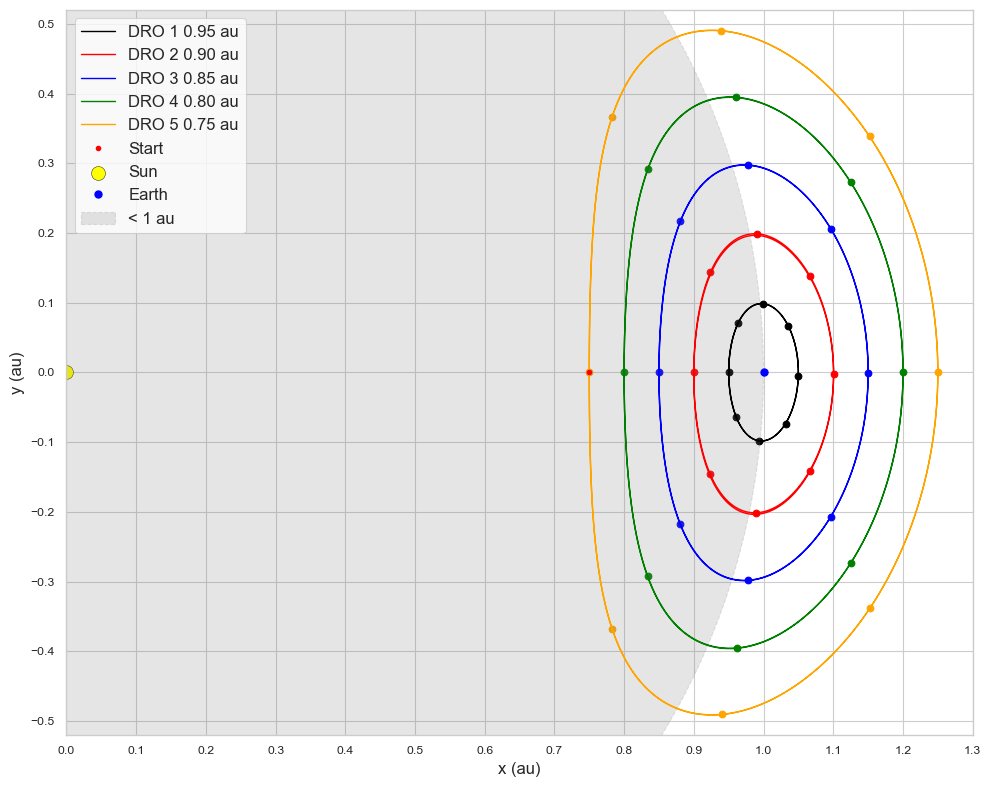

In [5]:

#plot spacecraft equidistant distribution on DRO 

#number of SHIELD spacecraft
nr_sc=8
t_all=365*1*24 # all time datapoints ****** need to set global time resolution better
interval=int(np.round(t_all/nr_sc)) #to nearest day
#indices of shield spacecraft equidistant in time over 1 year
shield_i=np.arange(0,t_all,interval)

print('Number of SHIELD Spacecraft:',nr_sc)
print('Interval in days:',interval/24)
print('longitudes:',np.round(np.rad2deg(dro_lon3[shield_i])))



sns.set_style('whitegrid')
sns.set_context('paper')   
# Create the plot
fig, ax = plt.subplots(figsize=(10, 10))

#third body
ax.plot(x1, y1, 'black', linewidth=1, alpha=1.0, label='DRO 1 0.95 au')
ax.plot(x2, y2, 'red', linewidth=1, alpha=1.0, label='DRO 2 0.90 au')
ax.plot(x3, y3, 'blue', linewidth=1, alpha=1.0, label='DRO 3 0.85 au')
ax.plot(x4, y4, 'green', linewidth=1, alpha=1.0, label='DRO 4 0.80 au')
ax.plot(x5, y5, 'orange', linewidth=1, alpha=1.0, label='DRO 5 0.75 au')


#with SHIELD distribution
ax.scatter(x1[shield_i],y1[shield_i],marker='o',c='black')
ax.scatter(x2[shield_i],y2[shield_i],marker='o',c='red')
ax.scatter(x3[shield_i],y3[shield_i],marker='o',c='blue')
ax.scatter(x4[shield_i],y4[shield_i],marker='o',c='green')
ax.scatter(x5[shield_i],y5[shield_i],marker='o',c='orange')



ax.plot(x0/au, y0/au, 'o', color='red', markersize=3, label='Start', zorder=4)

# Plot Sun - fixed at origin shifted by -mu*R
sun_x = -mu  
ax.scatter(0,0,s=100,c='yellow',alpha=1, edgecolors='black', linewidth=0.3, label='Sun')
# Plot Earth - fixed at (1-mu)
earth_x = (1 - mu) 
ax.plot(earth_x, 0, 'o', color='blue', markersize=5, label='Earth', zorder=5)


# Add distance circles for reference
circle = plt.Circle((sun_x, 0), 1, fill=True, color='gray', linestyle='--', alpha=0.2, label='< 1 au')
#circle = plt.Circle((sun_x, 0), 0.72, fill=False, color='gold', linestyle='--', alpha=0.8, label='Venus orbit radius')


ax.add_patch(circle)
# Formatting
ax.set_xlabel('x (au)', fontsize=12)
ax.set_ylabel('y (au)', fontsize=12)
#ax.set_title(f'Circular Restricted 3-Body Problem: Sun-Earth System\n(Rotating Reference Frame, {days} days simulation)', fontsize=14, fontweight='bold')
ax.legend(loc='upper left', fontsize=12)
ax.xaxis.set_major_locator(MultipleLocator(0.1))
ax.yaxis.set_major_locator(MultipleLocator(0.1))
ax.grid(True, alpha=1.0, linestyle='-')
ax.set_aspect('equal')
ax.set_xlim(0,1.3)
ax.set_ylim(-0.52,0.52)


plt.tight_layout()

plt.savefig('results/dro_cartesian_all.png', dpi=300,bbox_inches='tight')
plt.show()

## Plots for DRO characteristics

Slope: -65.3624
Intercept: 65.0103
R-squared: 0.9995
P-value: 4.6258e-06
Standard error: 0.8369
Coefficients (highest to lowest degree): [  24.47428571 -106.96868571   82.57058   ]


(0.0, 20.0)

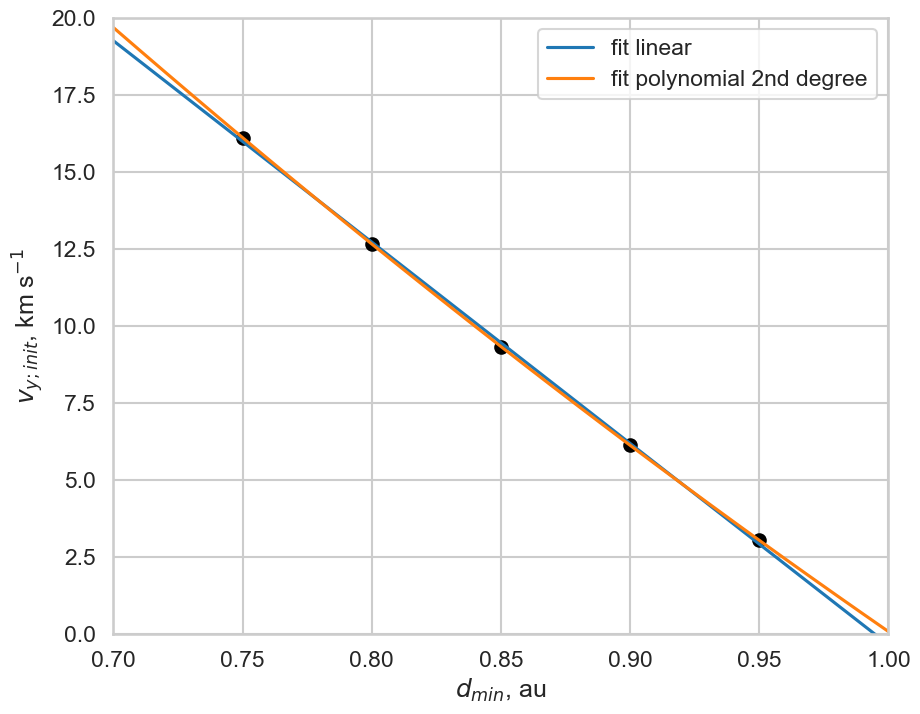

In [6]:
########### plot for initial speed and minimum distance to Sun

# Perform linear regression using scipy.stats.linregress
slope, intercept, r_value, p_value, std_err = stats.linregress(initial_x0_array, initial_vy_array)

# Print results
print(f"Slope: {slope:.4f}")
print(f"Intercept: {intercept:.4f}")
print(f"R-squared: {r_value**2:.4f}")
print(f"P-value: {p_value:.4e}")
print(f"Standard error: {std_err:.4f}")

x_fit = np.arange(0.7,1.0,0.01)
y_fit = x_fit*slope + intercept


# polynomial fit
coefficients = np.polyfit(initial_x0_array, initial_vy_array, deg=2)
print(f"Coefficients (highest to lowest degree): {coefficients}")
# Create polynomial function from coefficients
poly_func = np.poly1d(coefficients)

# Plot
y_fit_poly = poly_func(x_fit)




################################################## Create plots 
sns.set_style('whitegrid')
sns.set_context('talk')    
    
fig, ax = plt.subplots(1,figsize=(10, 8),dpi=100)   



########### dependence of initial vy peed on heliocentric distance
ax.scatter(initial_x0_array, initial_vy_array, c='black')

ax.plot(x_fit, y_fit, label='fit linear')
ax.plot(x_fit, y_fit_poly, label='fit polynomial 2nd degree')

ax.legend()
ax.set_xlabel('$d_{min}$, au')
ax.set_ylabel('$v_{y;init}$, km s$^{-1}$')

ax.set_xlim(0.7, 1.0)
ax.set_ylim(0,20)

Slope: -1.9605
Intercept: 1.9628
R-squared: 0.9999
P-value: 2.9824e-07
Standard error: 0.0101
 Factor for widest extension in y compared to distance from Earth:  [1.97766854 1.98942402 1.98557489 1.97598041 1.96350434]

[ 5.67135424 11.44872234 17.22447707 23.01989727 28.85639682]
Slope: -115.8889
Intercept: 115.7489
R-squared: 1.0000
P-value: 4.2940e-09
Standard error: 0.1447


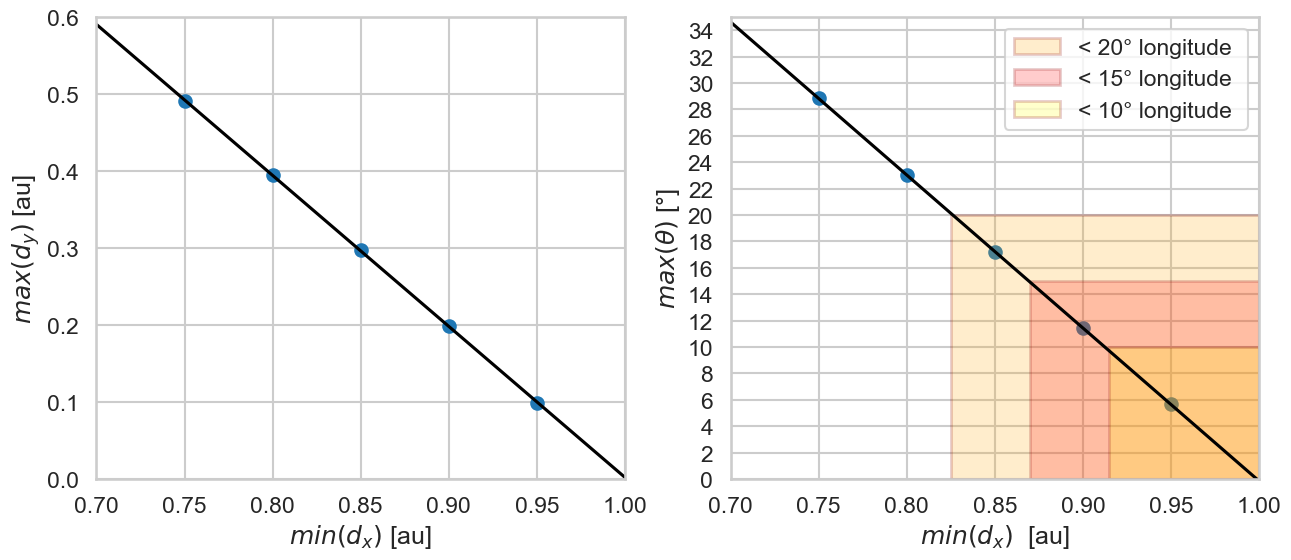

In [7]:
####### relationship between minimum distance and widest point in y in au 
sns.set_style('whitegrid')
sns.set_context('talk')    
    
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15, 6),dpi=100)

min_dro_x1_arr=np.array([np.min(dro_x1),np.min(dro_x2),np.min(dro_x3),np.min(dro_x4),np.min(dro_x5)])
max_dro_y1_arr=np.array([np.max(dro_y1),np.max(dro_y2),np.max(dro_y3),np.max(dro_y4),np.max(dro_y5)])

ax1.scatter(min_dro_x1_arr,max_dro_y1_arr)
ax1.set_xlabel('$min(d_{x})$ [au]')
ax1.set_ylabel('$max(d_{y})$ [au]')
ax1.set_xlim(0.7, 1.0)
ax1.set_ylim(0,0.6)

# Perform linear regression using scipy.stats.linregress
slope, intercept, r_value, p_value, std_err = stats.linregress(min_dro_x1_arr, max_dro_y1_arr)

# Print results
print(f"Slope: {slope:.4f}")
print(f"Intercept: {intercept:.4f}")
print(f"R-squared: {r_value**2:.4f}")
print(f"P-value: {p_value:.4e}")
print(f"Standard error: {std_err:.4f}")

y_fit1 = x_fit*slope + intercept
ax1.plot(x_fit,y_fit1, c='k')


print(' Factor for widest extension in y compared to distance from Earth: ',max_dro_y1_arr/(1-min_dro_x1_arr))



print()

####### relationship between minimum distance and widest point in y in longitude
max_dro_lon_arr=np.array(np.rad2deg([np.max(dro_lon1),np.max(dro_lon2),np.max(dro_lon3),np.max(dro_lon4),np.max(dro_lon5)]))

print(max_dro_lon_arr)
ax2.scatter(min_dro_x1_arr,max_dro_lon_arr)
ax2.set_xlabel('$min(d_{x})$  [au]')
ax2.set_ylabel(r'$max( \theta )$ [°]')
ax2.set_xlim(0.7, 1.0)
ax2.set_ylim(0,35)
ax2.yaxis.set_major_locator(MultipleLocator(2))

# Perform linear regression using scipy.stats.linregress
slope, intercept, r_value, p_value, std_err = stats.linregress(min_dro_x1_arr, max_dro_lon_arr)

# Print results
print(f"Slope: {slope:.4f}")
print(f"Intercept: {intercept:.4f}")
print(f"R-squared: {r_value**2:.4f}")
print(f"P-value: {p_value:.4e}")
print(f"Standard error: {std_err:.4f}")

y_fit2 = x_fit*slope + intercept
ax2.plot(x_fit,y_fit2, c='k')




# Rectangle((x_start, y_start), width, height)
box = Rectangle((0.825, 0), 0.175, 20, 
                facecolor='orange', 
                alpha=0.2,
                edgecolor='darkred',
                linewidth=2, label='< 20° longitude ')
ax2.add_patch(box)


# Rectangle((x_start, y_start), width, height)
box = Rectangle((0.87, 0), 0.15, 15, 
                facecolor='red', 
                alpha=0.2,
                edgecolor='darkred',
                linewidth=2, label='< 15° longitude ')
ax2.add_patch(box)


# Rectangle((x_start, y_start), width, height)
box = Rectangle((0.915, 0), 0.15, 10, 
                facecolor='yellow', 
                alpha=0.2,
                edgecolor='darkred',
                linewidth=2, label='< 10° longitude ')
ax2.add_patch(box)

ax2.legend()


Text(0, 0.5, 'longitude')

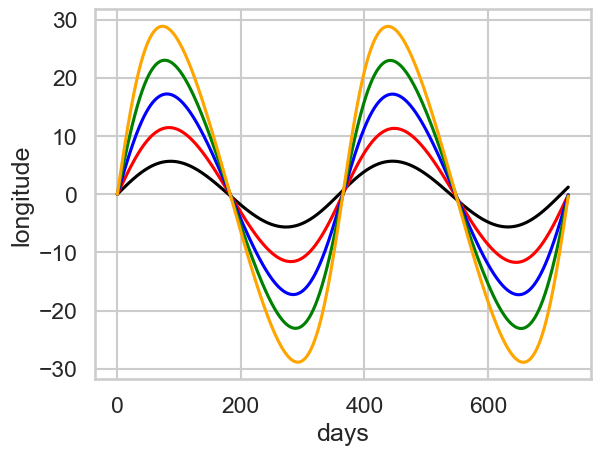

In [8]:
########## ORBITAL PERIOD Figure

#all take 1 year

#time axis same as for sim above in the function
years=2
days = 365*years  # Simulate for 1 year
t_span = (0, days * 86400)      # Time span for integration (in seconds)
t_eval = np.linspace(t_span[0], t_span[1], days*24) #time resolution is 1 hour, need to include better for arbitrary time arrays

plt.plot(t_eval/(86400),np.rad2deg(dro_lon1),c='black')
plt.plot(t_eval/(86400),np.rad2deg(dro_lon2),c='red')
plt.plot(t_eval/(86400),np.rad2deg(dro_lon3),c='blue')
plt.plot(t_eval/(86400),np.rad2deg(dro_lon4),c='green')
plt.plot(t_eval/(86400),np.rad2deg(dro_lon5),c='orange')


#with SHIELD distribution
#ax.scatter(x1[shield_i],y1[shield_i],marker='o',c='black')
#ax.scatter(x2[shield_i],y2[shield_i],marker='o',c='red')
#ax.scatter(x3[shield_i],y3[shield_i],marker='o',c='blue')
#ax.scatter(x4[shield_i],y4[shield_i],marker='o',c='green')
#ax.scatter(x5[shield_i],y5[shield_i],marker='o',c='orange')



plt.xlabel('days')
plt.ylabel('longitude')


### plot combined with planets in HEEQ

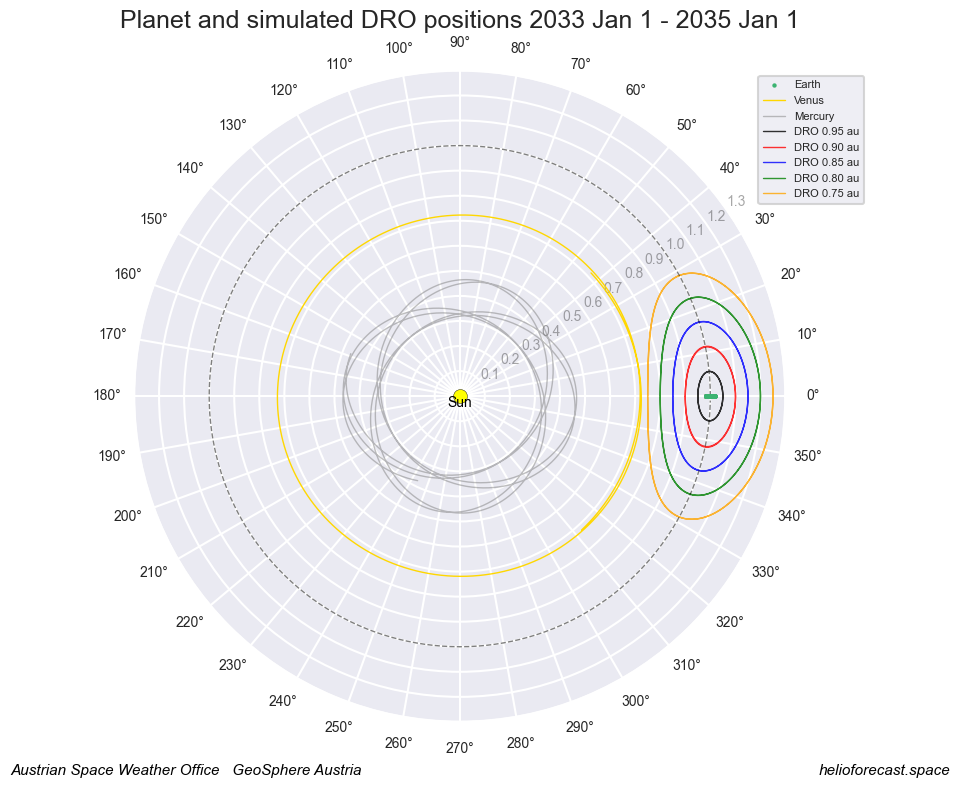

In [9]:
sns.set_style('darkgrid')
sns.set_context('talk')    
    
fig, ax = plt.subplots(1,figsize=(10, 8),subplot_kw={'projection': 'polar'},dpi=100)    
    
fsize=15
symsize_planet=10

ax.text(0,0,'Sun', color='black', ha='center',fontsize=fsize-5,verticalalignment='top')
#ax.text(0,1.2,'Earth', color='mediumseagreen', ha='center',fontsize=fsize-5,verticalalignment='center')


# Sun
ax.scatter(0,0,s=100,c='yellow',alpha=1, edgecolors='black', linewidth=0.3)
    

ax.scatter(earth.lon, earth.r, s=symsize_planet, c='mediumseagreen', alpha=1,lw=0,zorder=3,marker=None, label='Earth')  
ax.plot(venus.lon, venus.r, c='gold', alpha=1,lw=1,zorder=3, marker=None, label='Venus')  
ax.plot(mercury.lon, mercury.r, c='grey', alpha=0.5,lw=1,zorder=3, marker=None, label='Mercury')  

ax.plot(dro_lon1, dro_r1,c='black', alpha=0.8,lw=1, markersize=1, label='DRO 0.95 au')
ax.plot(dro_lon2, dro_r2,c='red', alpha=0.8,lw=1, markersize=1, label='DRO 0.90 au')
ax.plot(dro_lon3, dro_r3,c='blue', alpha=0.8,lw=1, markersize=1, label='DRO 0.85 au')
ax.plot(dro_lon4, dro_r4,c='green', alpha=0.8,lw=1, markersize=1, label='DRO 0.80 au')
ax.plot(dro_lon5, dro_r5,c='orange', alpha=0.8,lw=1, markersize=1, label='DRO 0.75 au')


#1 au circle
ax.plot(np.deg2rad(np.arange(0,360)),np.zeros(360)+1,lw=1,alpha=0.5,linestyle='--',c='black', marker=None)
     
#set axes
ax.set_theta_zero_location('E')
plt.rgrids((0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0,1.1,1.2,1.3,1.6,2.0,2.5),('0.1','0.2','0.3','0.4','0.5','0.6','0.7','0.8','0.9','1.0','1.1','1.2','1.3','1.6 AU','2.0','2.5'),angle=35, fontsize=fsize-5,alpha=0.4)

degrees = np.arange(0, 360, 10)
ax.set_xticks(np.radians(degrees))
ax.set_xticklabels([f'{d}°' for d in degrees], fontsize=10)

ax.legend(bbox_to_anchor=(0.95, 1), loc='upper left',fontsize=8)

plt.title('Planet and simulated DRO positions 2033 Jan 1 - 2035 Jan 1')
ax.set_ylim(0, 1.3) 
plt.tight_layout()


plt.figtext(0.05,0.01,'Austrian Space Weather Office   GeoSphere Austria', color='black', ha='left',fontsize=fsize-4, style='italic')
plt.figtext(0.99,0.01,'helioforecast.space', color='black', ha='right',fontsize=fsize-4, style='italic')

     

plt.savefig('results/dro_all_polar.png', dpi=300,bbox_inches='tight')

### same plot zoomed in with spacecraft distribution

Number of SHIELD Spacecraft: 8
Interval in days: 45.625
longitudes: [  0.  14.  17.  11.  -0. -11. -17. -14.]


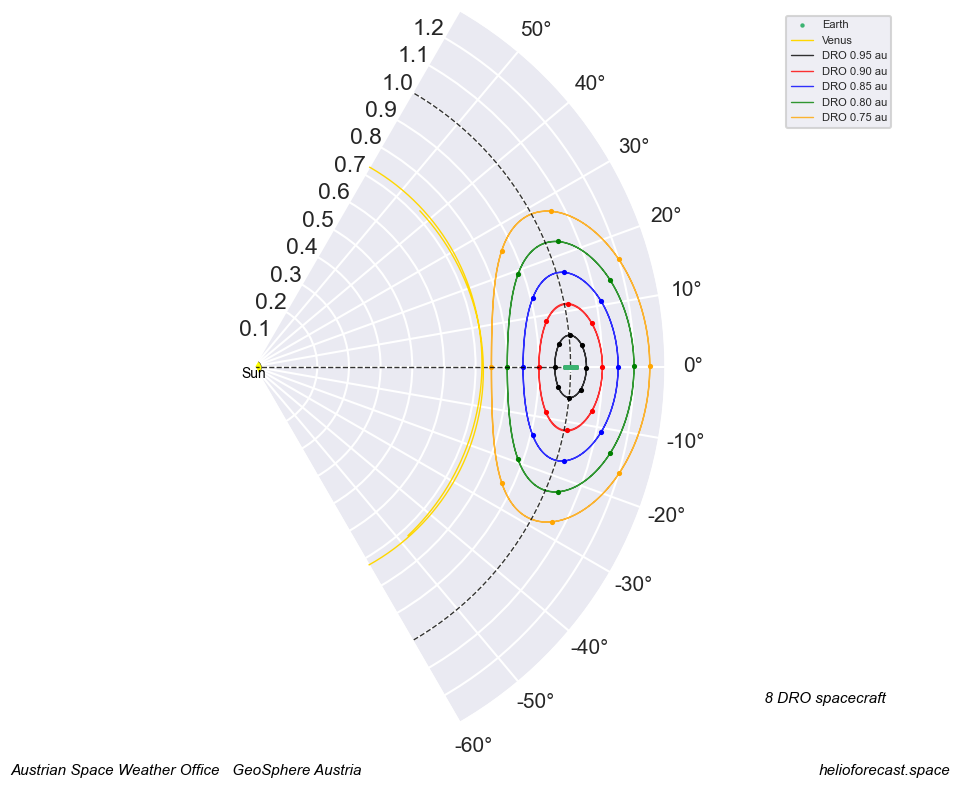

In [10]:
##plot spacecraft equidistant distribution on DRO 

#number of SHIELD spacecraft
nr_sc=8
t_all=365*1*24 # all time datapoints ****** need to set global time resolution better
interval=int(np.round(t_all/nr_sc)) #to nearest day **** to coarse, needs hours for 0.95 au case
#indices of shield spacecraft equidistant in time over 1 year
shield_i=np.arange(0,t_all,interval)

print('Number of SHIELD Spacecraft:',nr_sc)
print('Interval in days:',interval/24)
print('longitudes:',np.round(np.rad2deg(dro_lon3[shield_i])))


sns.set_style('darkgrid')
sns.set_context('talk')    
    
fig, ax = plt.subplots(1,figsize=(10, 8),subplot_kw={'projection': 'polar'},dpi=100)    
    
fsize=15
symsize_planet=10

ax.text(0,0,'Sun', color='black', ha='center',fontsize=fsize-5,verticalalignment='top')
#ax.text(0,1.2,'Earth', color='mediumseagreen', ha='center',fontsize=fsize-5,verticalalignment='center')

# Sun
ax.scatter(0,0,s=100,c='yellow',alpha=1, edgecolors='black', linewidth=0.3)

ax.scatter(earth.lon, earth.r, s=symsize_planet, c='mediumseagreen', alpha=1,lw=0,zorder=3,marker=None, label='Earth')  
ax.plot(venus.lon, venus.r, c='gold', alpha=1,lw=1,zorder=3, marker=None, label='Venus')  
#ax.plot(mercury.lon, mercury.r, c='grey', alpha=0.5,lw=1,zorder=3, marker=None, label='Mercury')  

ax.plot(dro_lon1, dro_r1,c='black', alpha=0.8,lw=1, markersize=1, label='DRO 0.95 au')
ax.plot(dro_lon2, dro_r2,c='red', alpha=0.8,lw=1, markersize=1, label='DRO 0.90 au')
ax.plot(dro_lon3, dro_r3,c='blue', alpha=0.8,lw=1, markersize=1, label='DRO 0.85 au')
ax.plot(dro_lon4, dro_r4,c='green', alpha=0.8,lw=1, markersize=1, label='DRO 0.80 au')
ax.plot(dro_lon5, dro_r5,c='orange', alpha=0.8,lw=1, markersize=1, label='DRO 0.75 au')


ax.scatter(dro_lon1[shield_i], dro_r1[shield_i],c='black', marker='o',s=5)
ax.scatter(dro_lon2[shield_i], dro_r2[shield_i],c='red', marker='o',s=5)
ax.scatter(dro_lon3[shield_i], dro_r3[shield_i],c='blue', marker='o',s=5)
ax.scatter(dro_lon4[shield_i], dro_r4[shield_i],c='green', marker='o',s=5)
ax.scatter(dro_lon5[shield_i], dro_r5[shield_i],c='orange', marker='o',s=5)

#1 au circle
ax.plot(np.deg2rad(np.arange(0,360)),np.zeros(360)+1,lw=1,alpha=0.8,linestyle='--',c='black', marker=None)
ax.plot(np.zeros(11),np.arange(0,1.1,0.1),c='k',lw=1,alpha=0.8,linestyle='--')




degrees = np.arange(-60,60,10)
ax.set_xticks(np.radians(degrees))
ax.set_xticklabels([f'{d}°' for d in degrees], fontsize=15)

ax.set_rgrids(np.arange(0.2,1.5,0.1),('0.1','0.2','0.3','0.4','0.5','0.6','0.7','0.8','0.9','1.0','1.1','1.2','1.3'),angle=50, fontsize=10)


ax.set_theta_zero_location('E')
ax.set_thetamin(60)      # Start angle in degrees
ax.set_thetamax(-60)
##plt.title('Planet and simulated DRO positions 2028 Jan 1 - 2030 Jan 1')
ax.set_ylim(0, 1.3) 


ax.legend(bbox_to_anchor=(0.95, 1), loc='upper left',fontsize=8)
plt.figtext(0.8,0.1,f' {nr_sc} DRO spacecraft', color='black', ha='left',fontsize=fsize-4, style='italic')
plt.figtext(0.05,0.01,'Austrian Space Weather Office   GeoSphere Austria', color='black', ha='left',fontsize=fsize-4, style='italic')
plt.figtext(0.99,0.01,'helioforecast.space', color='black', ha='right',fontsize=fsize-4, style='italic')

plt.tight_layout()

   
plt.savefig(f'results/dro_all_polar_zoom_{nr_sc}.png', dpi=300,bbox_inches='tight')

## Animations
use ffmpeg

plot spacecraft equidistant distribution on DRO 


In [11]:
sns.set_style('darkgrid')
sns.set_context('talk')    
    
############## number of SHIELD spacecraft #########
nr_sc=6
#################################################


t_all=365*1*24 # all time datapoints ****** need to set global time resolution better
interval=int(np.round(t_all/nr_sc)) #to nearest day
#indices of shield spacecraft equidistant in time over 1 year
shield_i=np.arange(0,t_all,interval)

print('Number of SHIELD Spacecraft:',nr_sc)
print('Interval in days:',interval/24)
print('longitudes:',np.round(np.rad2deg(dro_lon3[shield_i])))


def make_frame(i):


    fig, ax = plt.subplots(1,figsize=(10, 8),subplot_kw={'projection': 'polar'},dpi=200)    

    fsize=15
    symsize_planet=10

    ax.text(0,0,'Sun', color='black', ha='center',fontsize=fsize-5,verticalalignment='top')
    #ax.text(0,1.2,'Earth', color='mediumseagreen', ha='center',fontsize=fsize-5,verticalalignment='center')

    # Sun
    ax.scatter(0,0,s=100,c='yellow',alpha=1, edgecolors='black', linewidth=0.3)

    ax.scatter(earth.lon, earth.r, s=symsize_planet, c='mediumseagreen', alpha=1,lw=0,zorder=3,marker=None, label='Earth')  
    ax.plot(venus.lon, venus.r, c='gold', alpha=1,lw=1,zorder=3, marker=None, label='Venus')  
    #ax.plot(mercury.lon, mercury.r, c='grey', alpha=0.5,lw=1,zorder=3, marker=None, label='Mercury')  

    ax.plot(dro_lon1, dro_r1,c='black', alpha=0.8,lw=1, markersize=1, label='DRO 0.95 au')
    ax.plot(dro_lon2, dro_r2,c='red', alpha=0.8,lw=1, markersize=1, label='DRO 0.90 au')
    ax.plot(dro_lon3, dro_r3,c='blue', alpha=0.8,lw=1, markersize=1, label='DRO 0.85 au')
    ax.plot(dro_lon4, dro_r4,c='green', alpha=0.8,lw=1, markersize=1, label='DRO 0.80 au')
    ax.plot(dro_lon5, dro_r5,c='orange', alpha=0.8,lw=1, markersize=1, label='DRO 0.75 au')
    

    #advance by factor frames

    ax.scatter(dro_lon1[shield_i+i*factor], dro_r1[shield_i+i*factor],c='black', marker='o',s=5)
    ax.scatter(dro_lon2[shield_i+i*factor], dro_r2[shield_i+i*factor],c='red', marker='o',s=5)
    ax.scatter(dro_lon3[shield_i+i*factor], dro_r3[shield_i+i*factor],c='blue', marker='o',s=5)
    ax.scatter(dro_lon4[shield_i+i*factor], dro_r4[shield_i+i*factor],c='green', marker='o',s=5)
    ax.scatter(dro_lon5[shield_i+i*factor], dro_r5[shield_i+i*factor],c='orange', marker='o',s=5)
    

    #1 au circle
    ax.plot(np.deg2rad(np.arange(0,360)),np.zeros(360)+1,lw=1,alpha=0.8,linestyle='--',c='black', marker=None)

    ax.plot(np.zeros(11),np.arange(0,1.1,0.1),c='k',lw=1,alpha=0.8,linestyle='--')



    degrees = np.arange(-60,60,10)
    ax.set_xticks(np.radians(degrees))
    ax.set_xticklabels([f'{d}°' for d in degrees], fontsize=15)

    ax.set_rgrids(np.arange(0.2,1.5,0.1),('0.1','0.2','0.3','0.4','0.5','0.6','0.7','0.8','0.9','1.0','1.1','1.2','1.3'),angle=50, fontsize=10)


    ax.set_theta_zero_location('E')
    ax.set_thetamin(60)      # Start angle in degrees
    ax.set_thetamax(-60)
    ##plt.title('Planet and simulated DRO positions 2028 Jan 1 - 2030 Jan 1')
    ax.set_ylim(0, 1.3) 

    #ax.set_rgrids((0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0,1.1,1.2),('0.1','0.2','0.3','0.4','0.5','0.6','0.7','0.8','0.9','1.0','1.1','1.2'), angle=0, fontsize=5, alpha=0.1)
    ax.legend(bbox_to_anchor=(0.8, 1), loc='upper left',fontsize=10)
    plt.tight_layout()
    

    plt.figtext(0.2,0.8,f' {nr_sc} DRO spacecraft', color='black', ha='left',fontsize=fsize-4, style='italic')
    plt.figtext(0.2,0.75,f'time:   {np.round(i*factor/24,2)} days', color='black', ha='left',fontsize=fsize-4, style='italic')


    plt.figtext(0.05,0.01,'Austrian Space Weather Office   GeoSphere Austria', color='black', ha='left',fontsize=fsize-4, style='italic')
    plt.figtext(0.99,0.01,'helioforecast.space', color='black', ha='right',fontsize=fsize-4, style='italic')

    plt.savefig(f'results/frames/dro{i:04d}.jpg', dpi=200,bbox_inches='tight')
    plt.close()
    
    return 0

factor=12
make_frame(500)

Number of SHIELD Spacecraft: 6
Interval in days: 60.833333333333336
longitudes: [  0.  16.  13.  -0. -13. -16.]


0

In [ ]:
make_animation=True

if make_animation:

    print()
    print('make animation')
    print()
        
    ffmpeg_path=''
    outputdirectory = 'results/frames'
    animdirectory   = 'results/'
    
    factor=12
    i_all=int(365*24/factor) #365*24 for all frames for 1 year, 1 hour resolution, divided by factor
    counter=[i for i in range(i_all)]
    
    print('number of frames',i_all)
    
    used=8
    print('Using multiprocessing, nr of cores',mp.cpu_count(), \
          'with nr of processes used: ',used)
    
    #define pool using fork and number of processes
    pool=mp.get_context('fork').Pool(processes=used)
    # Map the worker function onto the parameters    
    t0 = time.time()
    pool.map(make_frame, counter) #or use apply_async?,imap
    pool.close()
    pool.join()     
    t1 = time.time()
    
    
    print('time in sec: ',np.round((t1-t0),1))
    print('plots done, frames saved in ',outputdirectory)


    movie_filename=f'dro_{nr_sc}'
    os.system(ffmpeg_path+'ffmpeg -r 25 -i '+str(outputdirectory)+'/dro%04d.jpg -b:v 5000k \
         '+str(animdirectory)+'/'+movie_filename+'.mp4 -y -loglevel quiet')    
    print('movie done, saved in ',animdirectory)
    
    os.system(ffmpeg_path+'ffmpeg -r 25 -i '+str(outputdirectory)+'/dro%04d.jpg -b:v 5000k \
         '+str(animdirectory)+'/'+movie_filename+'.gif -y -loglevel quiet')    





make animation

number of frames 730
Using multiprocessing, nr of cores 8 with nr of processes used:  8


### make one movie with HCI coordinates for visualizing how DROs rotate around Earth


In [ ]:
#use dro3 at 0.85 au
#generate Earth in HCI like above but in hours, then add the dros

start=datetime.datetime(2033,1,1)
end=datetime.datetime(2034,12,31,23)

times = [] 
dt=1 #time resolution is 1 hour
# Generate datetimes with increments of dt hours until the end date
current = start
while current <= end:
    times.append(current)
    current += datetime.timedelta(hours=dt)
    
earth_hci=get_planet_positions_hci(times,kernels_path, 'EARTH_BARYCENTER')


#this is one spacecraft, all the others are phase shifted, i.e. the orbit is not the same in this frame
dro3_x_hci=(dro3.x-1.0)+earth_hci.x/au
dro3_y_hci=dro3.y+earth_hci.y/au

dro3_r_hci= np.sqrt(dro3_x_hci**2 + dro3_y_hci**2)
dro3_lon_hci = np.arctan2(dro3_y_hci, dro3_x_hci)


#x_rot = x·cos(ωt) + y·sin(ωt)
#y_rot = -x·sin(ωt) + y·cos(ωt)

#make time in hour resolution for 2 years
#mtime= np.arange('2033-01-01', '2035-01-01', dtype='datetime64[h]')
#mtime_num=(mdates.date2num(mtime)-mdates.date2num(mtime)[0])*24 #convert to hours
#print(mtime_num)
#Earth is at 0,0, then move Earth and add dro3.x dro3.y to this
#earth_x_hci=
#earth_y_hci=
# omega is available in rad/s - rad per hour = *3600
#omega_hour=omega*3600

#dro3_x_hci=dro3.x*np.cos(omega_hour*mtime_num)+dro3.y*np.sin(omega_hour*mtime_num)
#dro3_y_hci=-dro3.x*np.sin(omega_hour*mtime_num)+dro3.y*np.cos(omega_hour*mtime_num)



In [ ]:
sns.set_style('darkgrid')
sns.set_context('talk')    
    
############## number of SHIELD spacecraft #########
nr_sc=1
#################################################


t_all=365*1*24 # all time datapoints ****** need to set global time resolution better
interval=int(np.round(t_all/nr_sc)) #to nearest day
#indices of shield spacecraft equidistant in time over 1 year
#shield_i=np.arange(0,t_all,interval)
shield_i=0

print('Number of SHIELD Spacecraft:',nr_sc)
print('Interval in days:',interval/24)
print('longitudes:',np.round(np.rad2deg(dro_lon3[shield_i])))


def make_frame_hci(i):


    fig, ax = plt.subplots(1,figsize=(10, 8),subplot_kw={'projection': 'polar'},dpi=200)    

    fsize=15
    symsize_planet=60
    spacecraft_size=10

    ax.text(0,0,'Sun', color='black', ha='center',fontsize=fsize-5,verticalalignment='top')
    #ax.text(0,1.2,'Earth', color='mediumseagreen', ha='center',fontsize=fsize-5,verticalalignment='center')

    # Sun
    ax.scatter(0,0,s=200,c='yellow',alpha=1, edgecolors='black', linewidth=0.3)
    #Earth
    ax.scatter(earth_hci.lon[shield_i+i*factor], earth_hci.r[shield_i+i*factor], s=symsize_planet, c='mediumseagreen', alpha=1,lw=0,zorder=3,marker=None, label='Earth')  
    #DRO spacecraft
    ax.scatter(dro3_lon_hci[shield_i+i*factor], dro3_r_hci[shield_i+i*factor],c='blue', marker='o',s=spacecraft_size)
    
    #this is the orbit in HCI
    #ax.plot(dro3_lon_hci, dro3_r_hci,c='blue')

    #1 au circle
    ax.plot(np.deg2rad(np.arange(0,360)),np.zeros(360)+1,lw=1,alpha=0.5,linestyle='--',c='black', marker=None)
    ax.plot(np.zeros(11),np.arange(0,1.1,0.1),c='k',lw=1,alpha=0.5,linestyle='--')

    degrees = np.arange(0,360,20)
    ax.set_xticks(np.radians(degrees))
    ax.set_xticklabels([f'{d}°' for d in degrees], fontsize=15)

    ax.set_rgrids(np.arange(0.1,1.5,0.1),('0.1','0.2','0.3','0.4','0.5','0.6','0.7','0.8','0.9','1.0','1.1','1.2','1.3','1.4'),angle=50, fontsize=10)

    ax.set_theta_zero_location('E')
    #ax.set_thetamin(60)      # Start angle in degrees
    #ax.set_thetamax(-60)
    ##plt.title('Planet and simulated DRO positions 2028 Jan 1 - 2030 Jan 1')
    ax.set_ylim(0, 1.35) 

    #ax.set_rgrids((0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0,1.1,1.2),('0.1','0.2','0.3','0.4','0.5','0.6','0.7','0.8','0.9','1.0','1.1','1.2'), angle=0, fontsize=5, alpha=0.1)
    #ax.legend(bbox_to_anchor=(0.8, 1), loc='upper left',fontsize=10)
    plt.tight_layout()
    

    plt.figtext(0.1,0.9,f'1 DRO spacecraft', color='black', ha='left',fontsize=fsize-4, style='italic')
    plt.figtext(0.1,0.85,f'time:   {np.round(i*factor/24,2)} days', color='black', ha='left',fontsize=fsize-4, style='italic')

    plt.figtext(0.05,0.01,'Austrian Space Weather Office   GeoSphere Austria', color='black', ha='left',fontsize=fsize-4, style='italic')
    plt.figtext(0.99,0.01,'helioforecast.space', color='black', ha='right',fontsize=fsize-4, style='italic')

    plt.savefig(f'results/frames_hci/dro{i:04d}.jpg', dpi=200,bbox_inches='tight')
    plt.close()
    #plt.show()
    
    return 0

factor=12
make_frame_hci(100)

In [ ]:
make_animation_hci=True

if make_animation_hci:

    print()
    print('make animation')
    print()
        
    ffmpeg_path=''
    outputdirectory = 'results/frames_hci'
    animdirectory   = 'results/'
    
    factor=12
    i_all=int(365*2*24/factor) #365*24 for all frames for 1 year, 1 hour resolution, divided by factor
    counter=[i for i in range(i_all)]
    
    print('number of frames',i_all)
    
    used=8
    print('Using multiprocessing, nr of cores',mp.cpu_count(), \
          'with nr of processes used: ',used)
    
    #define pool using fork and number of processes
    pool=mp.get_context('fork').Pool(processes=used)
    # Map the worker function onto the parameters    
    t0 = time.time()
    pool.map(make_frame_hci, counter) #or use apply_async?,imap
    pool.close()
    pool.join()     
    t1 = time.time()
    
    print('time in sec: ',np.round((t1-t0),1))
    print('plots done, frames saved in ',outputdirectory)

    movie_filename=f'dro_hci_{nr_sc}'
    os.system(ffmpeg_path+'ffmpeg -r 25 -i '+str(outputdirectory)+'/dro%04d.jpg -b:v 5000k \
         '+str(animdirectory)+'/'+movie_filename+'.mp4 -y -loglevel quiet')    
    print('movie done, saved in ',animdirectory)
    
    os.system(ffmpeg_path+'ffmpeg -r 25 -i '+str(outputdirectory)+'/dro%04d.jpg -b:v 5000k \
         '+str(animdirectory)+'/'+movie_filename+'.gif -y -loglevel quiet')    



### load ICMECAT to compare DROs with existing observations


In [ ]:
url='icmecat/HELIO4CAST_ICMECAT_v23.csv'
ic=pd.read_csv(url)
print(ic.keys())

#get indices for each target
imes=np.where(ic.sc_insitu=='MESSENGER')[0]
ivex=np.where(ic.sc_insitu=='VEX')[0]
iwin=np.where(ic.sc_insitu=='Wind')[0]
imav=np.where(ic.sc_insitu=='MAVEN')[0]
ijun=np.where(ic.sc_insitu=='Juno')[0]

ista=np.where(ic.sc_insitu=='STEREO-A')[0]
istb=np.where(ic.sc_insitu=='STEREO-B')[0]
ipsp=np.where(ic.sc_insitu=='PSP')[0]
isol=np.where(ic.sc_insitu=='SolarOrbiter')[0]
ibep=np.where(ic.sc_insitu=='BepiColombo')[0]
iuly=np.where(ic.sc_insitu=='ULYSSES')[0]


In [ ]:
##plot spacecraft equidistant distribution on DRO 

#number of SHIELD spacecraft
#nr_sc=8
t_all=365*1*24 # all time datapoints ****** need to set global time resolution better
interval=int(np.round(t_all/nr_sc)) #to nearest day
#indices of shield spacecraft equidistant in time over 1 year
shield_i=np.arange(0,t_all,interval)

print('Number of SHIELD Spacecraft:',nr_sc)
print('Interval in days:',interval/24)
print('longitudes:',np.round(np.rad2deg(dro_lon3[shield_i])))


sns.set_style('darkgrid')
sns.set_context('talk')    
    
fig, ax = plt.subplots(1,figsize=(10, 8),subplot_kw={'projection': 'polar'},dpi=100)    
    
fsize=15
symsize_planet=10

ax.text(0,0,'Sun', color='black', ha='center',fontsize=fsize-5,verticalalignment='top')
#ax.text(0,1.2,'Earth', color='mediumseagreen', ha='center',fontsize=fsize-5,verticalalignment='center')

# Sun
ax.scatter(0,0,s=100,c='yellow',alpha=1, edgecolors='black', linewidth=0.3)

ax.scatter(earth.lon, earth.r, s=symsize_planet, c='mediumseagreen', alpha=1,lw=0,zorder=3,marker=None, label='Earth')  
ax.plot(venus.lon, venus.r, c='gold', alpha=1,lw=1,zorder=1, marker=None, label='Venus')  
#ax.plot(mercury.lon, mercury.r, c='grey', alpha=0.5,lw=1,zorder=3, marker=None, label='Mercury')  

ax.plot(dro_lon1, dro_r1,c='black', alpha=0.8,lw=1, markersize=1, label='DRO 0.95 au')
ax.plot(dro_lon2, dro_r2,c='red', alpha=0.8,lw=1, markersize=1, label='DRO 0.90 au')
ax.plot(dro_lon3, dro_r3,c='blue', alpha=0.8,lw=1, markersize=1, label='DRO 0.85 au')
ax.plot(dro_lon4, dro_r4,c='green', alpha=0.8,lw=1, markersize=1, label='DRO 0.80 au')
ax.plot(dro_lon5, dro_r5,c='orange', alpha=0.8,lw=1, markersize=1, label='DRO 0.75 au')


#ax.scatter(dro_lon1[shield_i], dro_r1[shield_i],c='black', marker='o',s=5)
#ax.scatter(dro_lon2[shield_i], dro_r2[shield_i],c='red', marker='o',s=5)
#ax.scatter(dro_lon3[shield_i], dro_r3[shield_i],c='blue', marker='o',s=5)
#ax.scatter(dro_lon4[shield_i], dro_r4[shield_i],c='green', marker='o',s=5)
#ax.scatter(dro_lon5[shield_i], dro_r5[shield_i],c='orange', marker='o',s=5)

####### ICMECAT events

ms=3
al=0.6

#ax.plot(np.radians(ic.mo_sc_long_heeq[iuly]),ic.mo_sc_heliodistance[iuly],'o',markersize=ms,c='brown', alpha=al, label='Ulysses')
#ax.plot(np.radians(ic.mo_sc_long_heeq[imav]),ic.mo_sc_heliodistance[imav],'o',markersize=ms,c='orangered', alpha=al, label='MAVEN')

#only inner heliosphere
ax.plot(np.radians(ic.mo_sc_long_heeq[imes]),ic.mo_sc_heliodistance[imes],'o',markersize=ms,c='coral', alpha=al,label='MESSENGER')
ax.plot(np.radians(ic.mo_sc_long_heeq[ivex]),ic.mo_sc_heliodistance[ivex],'o',markersize=ms,c='orange', alpha=al,label='Venus Express')
ax.plot(np.radians(ic.mo_sc_long_heeq[istb]),ic.mo_sc_heliodistance[istb],'o',markersize=ms,c='royalblue', alpha=al,label='STEREO-B')
ax.plot(np.radians(ic.mo_sc_long_heeq[ijun]),ic.mo_sc_heliodistance[ijun],'o',markersize=ms,c='black',markerfacecolor='yellow',alpha=al,label='Juno')

#ax3.plot(ic.mo_sc_heliodistance[ijun],ic.mo_bmean[ijun],'o', c='black',markerfacecolor='yellow', alpha=al,ms=ms, label='Juno')

ax.plot(np.radians(ic.mo_sc_long_heeq[ista]),ic.mo_sc_heliodistance[ista],'o',markersize=ms, c='red', alpha=al, label='STEREO-A')
ax.plot(np.radians(ic.mo_sc_long_heeq[iwin]),ic.mo_sc_heliodistance[iwin],'o',markersize=ms, c='mediumseagreen', alpha=al, label='Wind')
ax.plot(np.radians(ic.mo_sc_long_heeq[ipsp]),ic.mo_sc_heliodistance[ipsp],'o',markersize=ms, c='black', alpha=al,label='Parker Solar Probe')
ax.plot(np.radians(ic.mo_sc_long_heeq[isol]),ic.mo_sc_heliodistance[isol],'o',markersize=ms, c='black',markerfacecolor='white', alpha=al, label='Solar Orbiter')
ax.plot(np.radians(ic.mo_sc_long_heeq[ibep]),ic.mo_sc_heliodistance[ibep],'o',markersize=ms, c='darkblue',markerfacecolor='lightgrey', alpha=al, label='BepiColombo')

plt.legend(loc=2,fontsize=10)
#1 au circle
ax.plot(np.deg2rad(np.arange(0,360)),np.zeros(360)+1,lw=1,alpha=0.8,linestyle='--',c='black', marker=None)
ax.plot(np.zeros(11),np.arange(0,1.1,0.1),c='k',lw=1,alpha=0.8,linestyle='--')




degrees = np.arange(-60,60,5)
ax.set_xticks(np.radians(degrees))
ax.set_xticklabels([f'{d}°' for d in degrees], fontsize=15)

ax.set_rgrids(np.arange(0.2,1.5,0.1),('0.1','0.2','0.3','0.4','0.5','0.6','0.7','0.8','0.9','1.0','1.1','1.2','1.3'),angle=50, fontsize=10)


ax.set_theta_zero_location('E')
ax.set_thetamin(60)      # Start angle in degrees
ax.set_thetamax(-60)
##plt.title('Planet and simulated DRO positions 2028 Jan 1 - 2030 Jan 1')
ax.set_ylim(0, 1.3) 


ax.legend(bbox_to_anchor=(0.9, 0.9), loc='upper left',fontsize=8)
#plt.figtext(0.8,0.1,f' {nr_sc} DRO spacecraft', color='black', ha='left',fontsize=fsize-4, style='italic')
plt.figtext(0.05,0.01,'Austrian Space Weather Office   GeoSphere Austria', color='black', ha='left',fontsize=fsize-4, style='italic')
plt.figtext(0.99,0.01,'helioforecast.space', color='black', ha='right',fontsize=fsize-4, style='italic')

plt.tight_layout()

   
plt.savefig(f'results/dro_all_icme_polar_zoom.png', dpi=300,bbox_inches='tight')
plt.savefig(f'results/dro_all_icme_polar_zoom.pdf', dpi=300,bbox_inches='tight')

### Plots for lead times

In [ ]:

##analysis of distance vs lead time of different types of CMEs, assuming radial propagating front

speed=400 #km/s
leadmax=(1.0-0.7)*au/speed/(3600)
print(f'lead time for 400 km/s wind for 0.7 au is {leadmax:.2f} hours')
print('This is the maximum plot range, so it includes Venus')


############### plot
sns.set_style('whitegrid')
sns.set_context('talk')    
    
fig, ax = plt.subplots(1,figsize=(12, 6),dpi=100)   

colors = ['red', 'orangered', 'gold', 'limegreen', 'dodgerblue', 'darkviolet', 'purple']

x_locations = [0.75, 0.8, 0.85, 0.9, 0.95, 0.99]
# Draw dashed vertical lines at each location, and L1
for x in x_locations:
    ax.axvline(x=x, color='gray', linestyle='--', linewidth=2)


k=0
for i in [400,600,800,1000,1500,2000,2500]:    
    speed=i #km/s
    leaddist=np.linspace(0.7,1.0,100)
    leadtime=(1.0-leaddist)*au/speed/(3600)
    #print(leadtime)
    ax.plot(leaddist,leadtime,label=f'{i} km s$^{{-1}}$',color=colors[k])
    k=k+1

ax.legend()    
ax.set_ylabel('Lead time for radially shaped fronts [hours]')
ax.set_xlabel('DRO spacecraft heliocentric distance [au]')
ax.set_ylim(0,32)
ax.set_yticks(np.arange(0,35,2))
ax.set_xticks(np.arange(0.7,1.0,0.025))

plt.tight_layout()

   
plt.savefig(f'results/dro_lead_time.png', dpi=300,bbox_inches='tight')
plt.savefig(f'results/dro_lead_time.pdf', dpi=300,bbox_inches='tight')


In [ ]:
#number of SHIELD spacecraft
#nr_sc=8
t_all=365*1*24 # all time datapoints ****** need to set global time resolution better
interval=int(np.round(t_all/nr_sc)) #to nearest day
#indices of shield spacecraft equidistant in time over 1 year
shield_i=np.arange(0,t_all,interval)

print('Number of SHIELD Spacecraft:',nr_sc)
print('Interval in days:',interval/24)
print('longitudes:',np.round(np.rad2deg(dro_lon3[shield_i])))


sns.set_style('whitegrid')
sns.set_context('talk')    
    
fig, ax = plt.subplots(1,figsize=(10, 8),subplot_kw={'projection': 'polar'},dpi=100)    
    
fsize=15
symsize_planet=10

#ax.text(0,0,'Sun', color='black', ha='center',fontsize=fsize-5,verticalalignment='top')
#ax.text(0,1.2,'Earth', color='mediumseagreen', ha='center',fontsize=fsize-5,verticalalignment='center')

# Sun
#ax.scatter(0,0,s=100,c='yellow',alpha=1, edgecolors='black', linewidth=0.3)

ax.scatter(earth.lon, earth.r, s=symsize_planet, c='mediumseagreen', alpha=1,lw=0,zorder=3,marker=None, label='Earth')  
ax.plot(venus.lon, venus.r, c='gold', alpha=1,lw=1,zorder=1, marker=None, label='Venus')  
#ax.plot(mercury.lon, mercury.r, c='grey', alpha=0.5,lw=1,zorder=3, marker=None, label='Mercury')  

ax.plot(dro_lon1, dro_r1,c='black', alpha=0.8,lw=1, markersize=1, label='DRO 0.95 au')
ax.plot(dro_lon2, dro_r2,c='red', alpha=0.8,lw=1, markersize=1, label='DRO 0.90 au')
ax.plot(dro_lon3, dro_r3,c='blue', alpha=0.8,lw=1, markersize=1, label='DRO 0.85 au')
ax.plot(dro_lon4, dro_r4,c='green', alpha=0.8,lw=1, markersize=1, label='DRO 0.80 au')
ax.plot(dro_lon5, dro_r5,c='orange', alpha=0.8,lw=1, markersize=1, label='DRO 0.75 au')


#ax.scatter(dro_lon1[shield_i], dro_r1[shield_i],c='black', marker='o',s=5)
#ax.scatter(dro_lon2[shield_i], dro_r2[shield_i],c='red', marker='o',s=5)
#ax.scatter(dro_lon3[shield_i], dro_r3[shield_i],c='blue', marker='o',s=5)
#ax.scatter(dro_lon4[shield_i], dro_r4[shield_i],c='green', marker='o',s=5)
#ax.scatter(dro_lon5[shield_i], dro_r5[shield_i],c='orange', marker='o',s=5)

plt.legend(loc=2,fontsize=10)
#1 au circle
ax.plot(np.deg2rad(np.arange(0,360)),np.zeros(360)+1,lw=1,alpha=0.8,linestyle='--',c='black', marker=None)
ax.plot(np.zeros(11),np.arange(0,1.1,0.1),c='k',lw=1,alpha=0.8,linestyle='--')

degrees = np.arange(-35,40,5)
ax.set_xticks(np.radians(degrees))
ax.set_xticklabels([f'{d}°' for d in degrees], fontsize=15)

ax.set_rgrids(np.arange(0.7,1.5,0.1),('0.6','0.7','0.8','0.9','1.0','1.1','1.2','1.3'),angle=50, fontsize=10)



##########################

theta_shade = np.linspace(np.deg2rad(-30), np.deg2rad(30), 50)
r_min = 0.7
r_max = 1.0
n_radial_segments = 50

#define scaling
#for 0.7 au, how much is it for 400 km/s solar wind, in hours?

speed=400 #km/s
leadmax=(1.0-0.7)*au/speed/(3600)
print(f'lead time for 400 km/s wind for 0.7 au is {leadmax:.2f} hours')

#########################



min_value = -leadmax # Yellow starts at 0.7 au
max_value = 0 # Red stops at 1.0 au

# Create a colormap from yellow to red
colors_list = ['yellow', 'orange', 'red']
cmap = LinearSegmentedColormap.from_list('yellow_red', colors_list, N=n_radial_segments)

# Store patches for colorbar
norm = plt.Normalize(vmin=min_value, vmax=max_value)
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
#sm.set_array([])

for i in range(n_radial_segments):

    # Calculate radial position for this segment
    r1 = i * (r_max-r_min) / n_radial_segments + r_min
    r2 = (i + 1) * (r_max-r_min) / n_radial_segments + r_min
    
    ratio = (i / n_radial_segments)
    #scaled_value =  min_value + ratio * (max_value - min_value)    )
    # Get color from colormap
    color = cmap(ratio)    
    ax.fill_between(theta_shade, r1, r2, alpha=0.4, color=color, edgecolor='none')

    # Interpolate color 
    #ratio = i / n_radial_segments    
    #color = (1-ratio, 1 - ratio, 1-ratio)    #black to white
    #ax.fill_between(theta_shade, r1, r2, alpha=0.4, color=color, edgecolor='none')


# Add colorbar
cbar = plt.colorbar(sm, ax=ax,location='bottom',shrink=0.5,pad=0.04, aspect=20)
cbar.set_label('Lead time [hours]',fontsize=10)
cbar.ax.tick_params(labelsize=12)
ticks = cbar.get_ticks()
# convert negative to positive so lead time = positive
cbar.set_ticks(np.arange(-35,5,5))
cbar.set_ticklabels([f'{int(abs(tick))}' for tick in ticks])



ax.set_theta_zero_location('E')
ax.set_thetamin(35)      # Start angle in degrees
ax.set_thetamax(-35)
##plt.title('Planet and simulated DRO positions 2028 Jan 1 - 2030 Jan 1')
#ax.set_ylim(0, 1.3) 

# cutout in r
ax.set_rmin(0.60)
ax.set_rmax(1.30)
ax.set_rorigin(0)


ax.legend(bbox_to_anchor=(0.9, 0.9), loc='upper left',fontsize=10)
#plt.figtext(0.8,0.1,f' {nr_sc} DRO spacecraft', color='black', ha='left',fontsize=fsize-4, style='italic')
plt.figtext(0.05,0.01,'Austrian Space Weather Office   GeoSphere Austria', color='black', ha='left',fontsize=fsize-4, style='italic')
plt.figtext(0.99,0.01,'helioforecast.space', color='black', ha='right',fontsize=fsize-4, style='italic')

################# 

plt.tight_layout()

   
plt.savefig(f'results/dro_all_polar_lead_time.png', dpi=300,bbox_inches='tight')
plt.savefig(f'results/dro_all_polar_lead_time.pdf', dpi=300,bbox_inches='tight')

## Analysis of distance to Sun-Earth line (in progress)

In [ ]:
#all dro orbits are dro1, dro2, dro3, dro4, dro5
#break down to time for each spacecraft

#distance to Sun-Earth line

dro3

In [ ]:
#i_all=int(365*24/factor) #365*24 for all frames for 1 year, 1 hour resolution, divided by factor
#counter=[i for i in range(i_all)]


############## number of SHIELD spacecraft #########
nr_sc=4
#################################################


t_all=365*1*24 # all time datapoints ****** need to set global time resolution better
interval=int(np.round(t_all/nr_sc)) #to nearest day
#indices of shield spacecraft equidistant in time over 1 year
shield_i=np.arange(0,t_all,interval)

print('Number of SHIELD Spacecraft:',nr_sc)
print('Interval in days:',interval/24)
print('longitudes:',np.round(np.rad2deg(dro_lon3[shield_i])))

#indices of each spacecraft at start
print(shield_i)

colors = ['red', 'orangered', 'gold', 'limegreen', 'dodgerblue', 'darkviolet', 'purple']

dlon=np.rad2deg(dro_lon3)

dtime=np.arange(0,len(dlon),1)/24 #in days

### plot each spacecraft longitude

sns.set_style('whitegrid')
sns.set_context('talk')    
    
fig, ax = plt.subplots(1,figsize=(12, 6),dpi=100)   

ax.plot(dtime,dlon)
ax.plot(dtime[shield_i],dlon[shield_i],marker='o', linestyle='None')
ax.set_ylabel('longitude [°]')
ax.set_xlabel('time [days]')


#plt.plot(dro_lon3[shield_i])